## Programming Assignment 5
#### In this assignment, you will be implementing Tomasi-Kanade	Factorization algorithm	for Rigid Structure from Motion.

### Task 1
#### Load the data file and generate a 2D image dataset	by generating an orthographic camera with optical axis paralle to the XY plane, which rotates around the teapot	in 10° increments and always looks towards the center of the object
#### Note: Code for loading the point cloud and visualizing it has been given to you. Further build on it and take images of the teapot and visualize them

In [0]:
import numpy as np
import math

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from scipy.io import loadmat
x = loadmat('/content/drive/My Drive/teapot.mat')

In [0]:
a = []
b = []
c = []
for points in x['verts']:
    a.append(points[0])
    b.append(points[1])
    c.append(points[2])

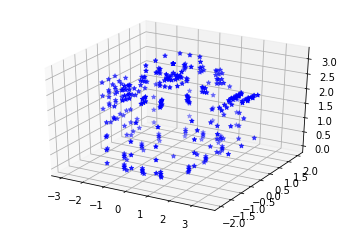

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,c, c='b', marker='*')

In [0]:
### Your implementation comes here
intrinsic = np.array([[1, 0, 0],[0, 1, 0]])

def rotation_matrix_y(angle):
    rot_angle=math.radians(angle)
    R = np.array([[math.cos(rot_angle),0,math.sin(rot_angle)],[0,1,0],[-math.sin(rot_angle),0,math.cos(rot_angle)]])
    return R      

In [0]:
a = np.asarray(a)
b = np.asarray(b)
c = np.asarray(c)


In [0]:
F = 3

In [0]:
### Your implementation comes here
# Hint: new2Dpts = K[R|T]*3DPoints

# Making a matrix out of all the 3d points by concatenating the points together

points_3d = np.vstack((a,b,c))
image_3d_frames = []
image_3d_frames.append(points_3d)
rot_matrix = rotation_matrix_y(10)


for i in range(F-1):
  image_3d_rotated = np.dot(rot_matrix,image_3d_frames[i])
  image_3d_frames.append(image_3d_rotated)


image_3d_frames = np.asarray(image_3d_frames)


In [52]:
image_3d_frames.shape

(3, 3, 306)

In [53]:
points_3d.shape

(3, 306)

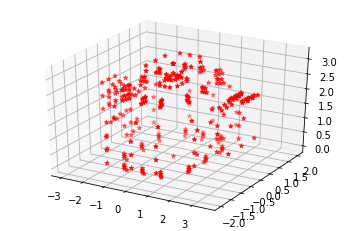

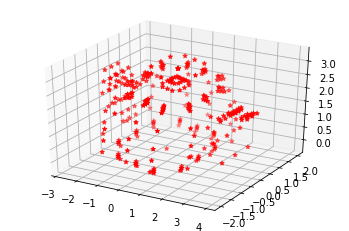

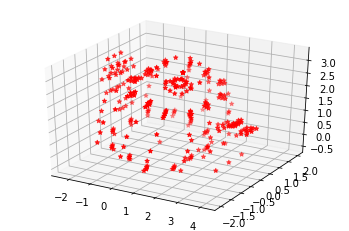

In [54]:
# Plotting the image frames we have generated

for i in range(image_3d_frames.shape[0]):
  x = image_3d_frames[i,0,:]
  y = image_3d_frames[i,1,:]
  z = image_3d_frames[i,2,:]
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x,y,z, c='r', marker='*')






In [55]:
points_3d.shape

(3, 306)

In [0]:
### Your implementation comes here
# Hint: new2Dpts = K[R|T]*3DPoints

W_matrix = np.zeros((2*F,points_3d.shape[1]))

init_angle = 0
for i in range(F):
  rot_mat = rotation_matrix_y(init_angle)
  # Getting our Camera Matrix
  cam_mat = np.dot(intrinsic,rot_mat)
  temp_2d = np.dot(cam_mat,points_3d)
  
  W_matrix[i*2:i*2+2,:] = temp_2d
  init_angle +=10


### Task 2
#### Use the data generated in previous task to generate a W matrix, and use that as input in Tomasi Kanade Factorization method to compute the 3D structure

In [0]:
### Your implementation for Tomasi Kanade Factorization method comes here

# Computing SVD

U, S, V = np.linalg.svd(W_matrix)
U = U[:,:3]
V = V[0:3,:]
S = S[0:3]
S = np.diag(S)


In [58]:
V.shape

(3, 306)

In [0]:
R_hat = U
S_hat = np.dot(S,V)

In [60]:
R_hat.shape

(6, 3)

In [0]:
# Computing the Q matrix i.e the linear constraint

rows = R_hat.shape[0] + int(0.5*R_hat.shape[0])
cols = 6

A_matrix = np.zeros((rows,cols))

In [62]:
A_matrix.shape

(9, 6)

In [0]:
# Constructing the A_Matrix

T_Matrix = []
for i in range(0,R_hat.shape[0],2):
  row_1 = R_hat[i]
  row_2 = R_hat[i+1]

  
  for j in range(3):
    T_1_Matrix = []

    if j == 0:
      for m in range(len(row_1)):
          for n in range(m,len(row_1)):
            val = row_1[m]*row_1[n]
            if m != n:
              val*=2
            T_1_Matrix.append(val)  
      T_Matrix.append(T_1_Matrix)

    if j == 1:
      for m in range(len(row_2)):
        for n in range(m,len(row_1)):
          val = row_2[m]*row_1[n]
          if m != n:
            val+= row_1[m] *row_2[n]
          T_1_Matrix.append(val) 
      T_Matrix.append(T_1_Matrix)

    if j == 2:
      for m in range(len(row_2)):
          for n in range(m,len(row_2)):
            val = row_2[m]*row_2[n]
            if m != n:
              val*=2
            T_1_Matrix.append(val)  
      T_Matrix.append(T_1_Matrix)



In [0]:
# B
eqn = [1,0,1]
ans_col = []
for i in range(F):
  ans_col.append(eqn)

ans_col = np.asarray(ans_col).reshape(F*3,1)

In [65]:
T_Matrix = np.asarray(T_Matrix)
T_Matrix.shape

(9, 6)

In [0]:
# Solving least squares using Moore-Penrose Inverse

x = np.linalg.pinv(T_Matrix)
Q = np.dot(x,ans_col)

In [67]:
Q.shape


(6, 1)

In [0]:
# Constructing a 3x3 Matrix

Q_new = [ [Q[0],Q[1],Q[2]], [Q[1] ,Q[3],Q[4]],[Q[2],Q[4],Q[5]] ]
Q_new = np.asarray(Q_new)

In [0]:
Q_new = Q_new.reshape(3,3)

In [0]:
# Computing the Cholesky Decomposition
Q1 = np.linalg.cholesky(Q_new)

In [0]:
# Computing R AND S
Q1_inv = np.linalg.inv(Q1)
R = np.dot(R_hat,Q1)
S = np.dot(Q1_inv,S_hat)

In [0]:
a1 = S[0,:]
b1 = S[1,:]
c1 = S[2,:]

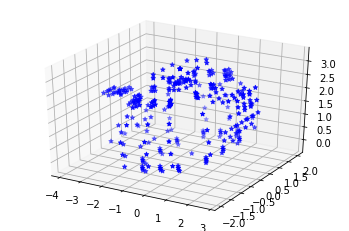

In [73]:
## Plot the reconstructed mode

# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the reconstructed 3D points are 
# in variables a1, b1 and c1 respectively, the reconstructed model can be plotted as:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a1,b1,c1, c='b', marker='*')

In [74]:
## Evaluate your reconstruction
# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the 3D points that you have reconstructed are 
# in variables a1, b1 and c1 respectively, the error in reconstruction can be calcualted as:

err = 0.0
j = 0
for i in range(len(a1)):
  err = err + math.sqrt( ((a1[i]-a[i])*(a1[i]-a[i])) + ((b1[i]-b[i])*(b1[i]-b[i])) + ((c1[i]-c[i])*(c1[i]-c[i])) )
  j=j+1
  
print ("Mean Euclidean Error : ",(err/j))

Mean Euclidean Error :  2.794390231574597
